In [28]:
import numpy as np
from numpy.fft import rfft,irfft, rfftfreq
import scipy
import scipy.interpolate as scint
import vlsr
import vlsr_iraf
from xkeckhelio import x_keckhelio
import fitsio
dir='/astro/u/anze/bmxdata/reduced/pas/191009_2100'
import matplotlib.pyplot as plt
import bmxhi4
from matplotlib.colors import LogNorm
from astropy.coordinates import EarthLocation, AltAz,SkyCoord
from astropy import coordinates as coord
import astropy.units as u
from astropy.time import Time


In [4]:
mjd=fitsio.read(dir+'/mjd.fits')['mjd'][::32]
coords=fitsio.read(dir+'/coords.fits')
dec=coords['dec'][::32]/np.pi*180
ra=coords['ra'][::32]/np.pi*180

In [168]:
keck=np.squeeze(np.array([x_keckhelio(r,d,m) for r,d,m in zip(ra,dec,mjd)]))

[-1.2535594e-05  3.9547207e-03  7.9220356e-03 ...  9.9030250e-01
  9.9060953e-01  9.9091107e-01] X


        Use `lat` instead. [warnings]


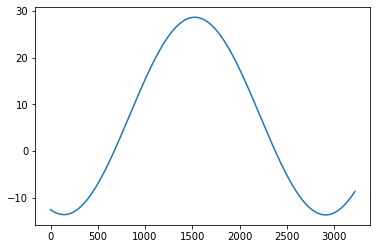

In [178]:
v1=vlsr(ra,dec,mjd)
v2=vlsr_iraf.vlsr(ra,dec,mjd)

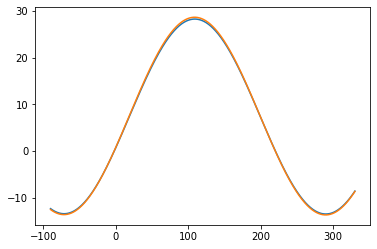

In [179]:
plt.plot(ra,-keck)
plt.plot(ra,v1[1])
#plt.plot(v1[1][500:550],'bo')
#plt.plot(ra,np.hstack((v1[1][:522],-v1[1][2238:522:-1],v1[1][2238:])))

[0.9999892  0.99999666 0.99999994 0.99999875 0.9999933 ] X


        Use `lat` instead. [warnings]


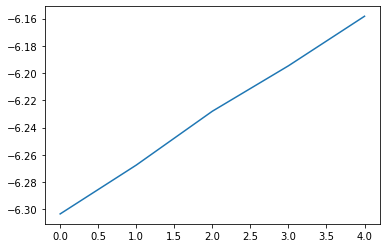

In [177]:
telescope_loc = EarthLocation(lat=40.87792*u.deg, lon=-72.85852*u.deg, height=0*u.m)

def vlsr(ra_deg, dec_deg, mjd):
    """RA, Dec in degrees. Return corrections that must be added to observed
    radial velocity to correct to local standard of rest."""

    ra_apex = (18.0 * 360./24.)*np.pi/180
    dec_apex = 30.0*np.pi/180
    
    ra = ra_deg * np.pi/180
    dec = dec_deg * np.pi/180

    # Solar motion w.r.t. LSR in km/s
    v_sun = 19.5*(np.cos(ra_apex)*np.cos(dec_apex)*np.cos(ra)*np.cos(dec) + 
                  np.sin(ra_apex)*np.cos(dec_apex)*np.sin(ra)*np.cos(dec) +
                  np.sin(dec_apex)*np.sin(dec))

    
    # Earth orbital motion w.r.t. sun
    c = SkyCoord(ra=ra_deg*u.deg, dec=dec_deg*u.deg, frame='icrs')
    ep = 23.4 * np.pi/180 # obliquity of ecliptic

    beta = np.arcsin((np.sin(dec)*np.cos(ep) - np.cos(dec)*np.sin(ra)*np.sin(ep)))
    print (np.cos(dec)*np.cos(ra)/np.cos(beta),'X')
    coslam = np.cos(dec)*np.cos(ra)/np.cos(beta)
    sinlam = np.cos(dec)*np.sin(ra)*np.cos(ep)+ np.sin(dec)*np.sin(ep)
    lam=np.arccos(coslam)
    lam[sinlam<0]*=-1
    
    time = Time(mjd, format='mjd')
    csun = coord.get_sun(time)
    ras  = csun.ra.deg  * np.pi/180
    decs = csun.dec.deg * np.pi/180
    beta_s = np.arcsin(np.sin(decs)*np.cos(ep) - np.cos(decs)*np.sin(ras)*np.sin(ep))
    coslam_s = np.cos(decs)*np.cos(ras)/np.cos(beta_s)
    sinlam_s = np.cos(decs)*np.sin(ras)*np.cos(ep)+ np.sin(decs)*np.sin(ep)
    lam_s = np.arccos(coslam_s)
    lam_s [sinlam_s<0]*=-1
    
    V = 29.974 # km/s
    e = 0.0167
    mjd0 = Time('1900-01-01', format='iso').mjd
    T = (mjd - mjd0)/365.25/100.
    gamma = 281.0 + 13./60 + 15.00/3600 + 6189.03*T/3600 + 1.63*T**2/3600
    gamma = gamma * np.pi/180


    v_earth = V*np.cos(beta)*(e*np.sin(gamma + lam) -
                 np.sin(lam - lam_s  ))
    plt.plot(v_earth)
    
    # Earth rotational axis
    Ve = 0.465 # km/s
    h = 0 # assumes zenith pointing, hour angle always zero
    v_rot = Ve * np.sin(h)*np.cos(dec)*np.cos(telescope_loc.latitude.rad)
    
    return v_sun, v_earth, v_rot



aa=vlsr(ra[520:525],dec[520:525],mjd[520:525])
#bb=vlsr(ra[2236:2241],dec[2236:2241],mjd[2236:2241])
#aa=vlsr(ra[300:2500],dec[300:2500],mjd[300:2500])

In [166]:
aa

(array([11.200237, 11.173293, 11.146325, 11.119331, 11.092313],
       dtype=float32),
 array([-6.1151132 , -6.16271142, -6.21394994, -6.25891996, -6.30686449]),
 array([0., 0., 0., 0., 0.], dtype=float32))

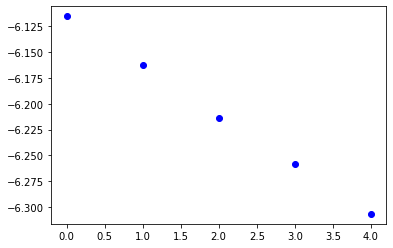

In [167]:
plt.plot(aa[1],'bo')
#plt.plot(-bb[1],'bo')